# Forecasting System


Energy Sector

# Preprocessing

In [131]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler


In [132]:
file_path = 'energy_dataset.csv'
df = pd.read_csv(file_path)
df= df.head(1000)

# Choosing selective columns to do preprocessing on 
df = df[['time', 'forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual',  'price actual', 'generation wind offshore', 
         'generation wind onshore', 'price day ahead', 'generation solar']]


Cleaning

In [133]:
missing_values_energy = df.isnull().sum()

print("** MISSING VALUES ***")
print("")
print(missing_values_energy)

df = df.dropna()


** MISSING VALUES ***

time                                0
forecast solar day ahead            0
forecast wind onshore day ahead     0
total load forecast                 0
total load actual                  18
price actual                        0
generation wind offshore           11
generation wind onshore            11
price day ahead                     0
generation solar                   11
dtype: int64


In [134]:
missing_values_energy_after_dropping = df.isnull().sum()

print(" *** MISSING VALUES AFTER DROPPING THE ROWS ***")
print ("")
print(missing_values_energy_after_dropping)


 *** MISSING VALUES AFTER DROPPING THE ROWS ***

time                               0
forecast solar day ahead           0
forecast wind onshore day ahead    0
total load forecast                0
total load actual                  0
price actual                       0
generation wind offshore           0
generation wind onshore            0
price day ahead                    0
generation solar                   0
dtype: int64


Normalization

In [135]:

columns_to_normalize_energy = ['forecast solar day ahead', 'forecast wind onshore day ahead', 'total load forecast', 
                               'total load actual', 'price actual', 'generation wind offshore', 'generation wind onshore', 
                               'price day ahead', 'generation solar']

scaler_energy = MinMaxScaler()

df[columns_to_normalize_energy] = scaler_energy.fit_transform(df[columns_to_normalize_energy])


Stationarization

In [136]:
# Applied differencing here to make data stationarity
# To make data stationary we apply differencing
# This involves subtracting the previous value from the current value

for column in columns_to_normalize_energy:
    df[f'{column}_diff'] = df[column].diff()
    

In [137]:
# Then here did log transformation

for column in columns_to_normalize_energy:
    df[f'log_{column}'] = np.log(df[column] + 1)                    #  I added the +1 to avoid log(0)
    

In [138]:
# After doing log transforming we are bound to get 0 in the first row 
# As log(1) = 0

# So again checking for missing values after doing the transformation

missing_values_energy1 = df.isnull().sum()
print("*** MISSING VALUES AFTER DOING TRANSFORMATION ***")
print("")
print(missing_values_energy1)

df = df.dropna()


*** MISSING VALUES AFTER DOING TRANSFORMATION ***

time                                    0
forecast solar day ahead                0
forecast wind onshore day ahead         0
total load forecast                     0
total load actual                       0
price actual                            0
generation wind offshore                0
generation wind onshore                 0
price day ahead                         0
generation solar                        0
forecast solar day ahead_diff           1
forecast wind onshore day ahead_diff    1
total load forecast_diff                1
total load actual_diff                  1
price actual_diff                       1
generation wind offshore_diff           1
generation wind onshore_diff            1
price day ahead_diff                    1
generation solar_diff                   1
log_forecast solar day ahead            0
log_forecast wind onshore day ahead     0
log_total load forecast                 0
log_total load actual    

# Using the Preproccesed dataset

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [140]:
# Saving the preprocessed dataframe to a new CSV file

preprocessed_file_path = 'new_energy_data.csv'

df.to_csv(preprocessed_file_path, index=False)

In [141]:

file_path = 'new_energy_data.csv'
df_preprocessed = pd.read_csv(file_path)


In [142]:

# Making sure that the 'time' column is parsed as datetime

df_preprocessed['time'] = pd.to_datetime(df_preprocessed['time'])
df_preprocessed.set_index('time', inplace=True)


In [143]:
# Target Column
target_column = 'total load actual'

# Checking if there are no NaN values in the target column
df_preprocessed = df_preprocessed.dropna(subset=[target_column])


In [144]:
# Splitting the data into training set and testing set

train_size = int(len(df_preprocessed) * 0.8)
train, test = df_preprocessed.iloc[:train_size], df_preprocessed.iloc[train_size:]

# Autoregressive Integrated Moving Average (ARIMA)

In [145]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import pickle

Check for stationarity using the ADF test

In [146]:
result = adfuller(df_preprocessed[target_column])

print('ADF STATS:', result[0])
print("")
print('P-VALUE:', result[1])
print("")

if result[1] > 0.05:
    
    print(" *** DATA IS NOT STATIONARY ***")

else:
    print("*** DATA IS STATIONARY ***")

ADF STATS: -3.094500941428912

P-VALUE: 0.026962829043734884

*** DATA IS STATIONARY ***


Plotting ACF and PACF to find p and q

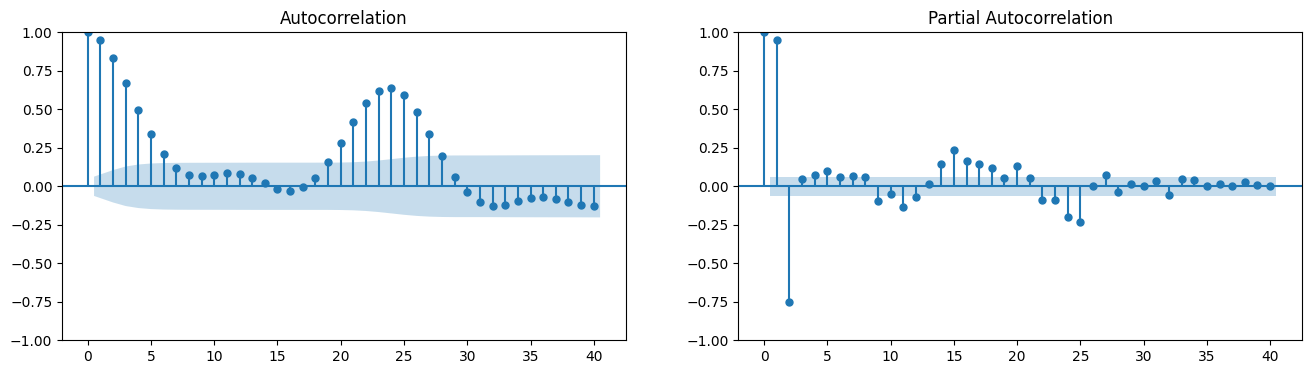

In [147]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

sm.graphics.tsa.plot_acf(df_preprocessed[target_column], lags=40, ax=axes[0])
sm.graphics.tsa.plot_pacf(df_preprocessed[target_column], lags=40, ax=axes[1])

plt.show()

Fitting the ARIMA Model

In [148]:

model = ARIMA(train[target_column], order=(1, 1, 1)) 

model_fit = model.fit()

# Saving the model
with open('arima_model.pkl', 'wb') as file:
    pickle.dump(model_fit, file)

# Loading the model
with open('arima_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g

Forecasting

In [149]:

forecast_steps = len(test)

forecast = loaded_model.predict(start=len(train), end=len(train) + forecast_steps - 1)



C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [150]:
# Calculating  RMSE, MAE, and MAPE

rmse_loaded = np.sqrt(mean_squared_error(test[target_column], forecast))

mae_loaded = mean_absolute_error(test[target_column], forecast)

mape_loaded = mean_absolute_percentage_error(test[target_column], forecast)


print(f'Root Mean Squared Error = {rmse_loaded}')
print("")
print(f'Mean Absolute Error = {mae_loaded}')
print("")
print(f'Mean Absolute Percentage Error = {mape_loaded}')


Root Mean Squared Error = 0.3491319911092562

Mean Absolute Error = 0.29128803372622897

Mean Absolute Percentage Error = 5.690330650121977


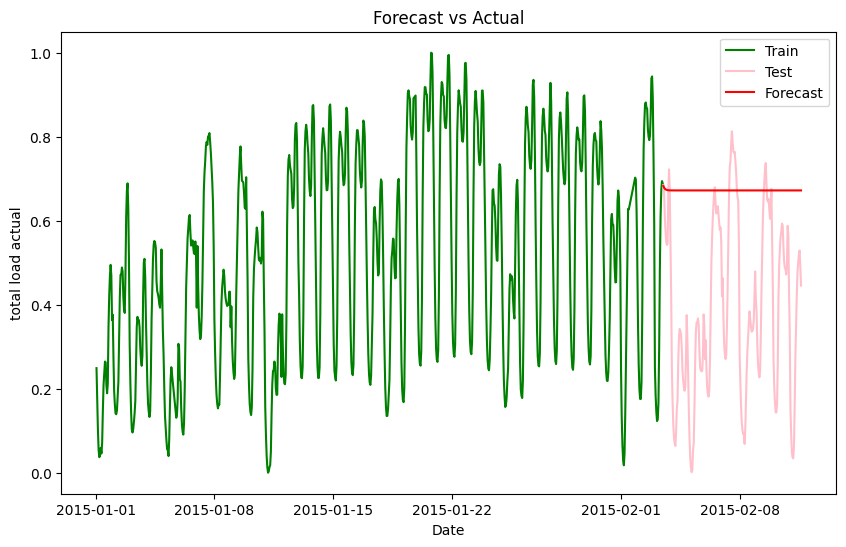

In [151]:
plt.figure(figsize=(10, 6))

plt.plot(train.index, train[target_column], label='Train', color = 'green')
plt.plot(test.index, test[target_column], label='Test', color='pink')
plt.plot(test.index, forecast, label='Forecast', color='red')

plt.legend()

plt.xlabel('Date')
plt.ylabel(target_column)

plt.title(f'Forecast vs Actual')

plt.show()

# Artificial Neural Networks (ANN)

In [152]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [153]:

train_mean = train[target_column].mean()
train_std = train[target_column].std()

train_scaled = (train[target_column] - train_mean) / train_std
test_scaled = (test[target_column] - train_mean) / train_std

In [154]:

# Preparing the data for the ANN model

def create_dataset(data, time_step=1):
    
    X, Y = [], []

    for i in range(len(data) - time_step):

        X.append(data[i:(i + time_step)])
        Y.append(data[i + time_step])

    return np.array(X), np.array(Y)

In [155]:
time_step = 10

X_train, y_train = create_dataset(train_scaled.values, time_step)
X_test, y_test = create_dataset(test_scaled.values, time_step)

# Reshaping the input to be samples, time steps, features 

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


Designing the ANN model

In [156]:
model = Sequential()

model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))

model.add(Dense(25))
model.add(Dense(1))


# Compiling
model.compile(optimizer='adam', loss='mean_squared_error')

# Training
model.fit(X_train, y_train, batch_size=1, epochs=10)

# Saving
model.save('ann_model.h5')

# Loading
loaded_model = tf.keras.models.load_model('ann_model.h5')

Epoch 1/10


C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


771/771 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.4543
Epoch 2/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0649
Epoch 3/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0378
Epoch 4/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0447
Epoch 5/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0483
Epoch 6/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0447
Epoch 7/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0416
Epoch 8/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0356
Epoch 9/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0392
Epoch 10/10
771/771 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0376


Forecasting

In [157]:
train_predict = loaded_model.predict(X_train)

test_predict = loaded_model.predict(X_test)



train_predict = train_predict * train_std + train_mean

test_predict = test_predict * train_std + train_mean


y_test_actual = test[target_column].iloc[time_step:].values

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [158]:

rmse_loaded = np.sqrt(mean_squared_error(y_test_actual, test_predict))

mae_loaded = mean_absolute_error(y_test_actual, test_predict)

mape_loaded = mean_absolute_percentage_error(y_test_actual, test_predict)


print(f'Root Mean Squared Error = {rmse_loaded}')
print("")
print(f'Mean Absolute Error = {mae_loaded}')
print("")
print(f'Mean Absolute Percentage Error = {mape_loaded}')

Root Mean Squared Error = 0.048369417206471525

Mean Absolute Error = 0.03306188847614486

Mean Absolute Percentage Error = 0.2514948890772579


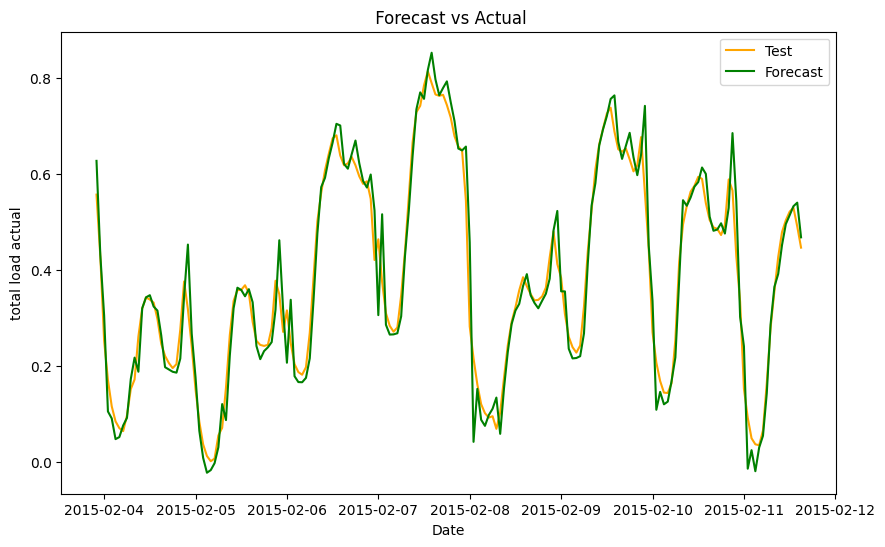

In [159]:

plt.figure(figsize=(10, 6))

plt.plot(test.index[time_step:], y_test_actual, label='Test', color='orange')
plt.plot(test.index[time_step:], test_predict, label='Forecast', color='green')

plt.legend()

plt.xlabel('Date')
plt.ylabel(target_column)

plt.title(f' Forecast vs Actual')

plt.show()


# SARIMA (Seasonal ARIMA)

In [160]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Checking for stationarity using the ADF test

In [161]:
result = adfuller(df_preprocessed[target_column])

print('ADF STATS:', result[0])
print("")
print('P-VALUE:', result[1])
print("")

if result[1] > 0.05:
    
    print(" *** DATA IS NOT STATIONARY ***")

else:
    print("*** DATA IS STATIONARY ***")

ADF STATS: -3.094500941428912

P-VALUE: 0.026962829043734884

*** DATA IS STATIONARY ***


Plotting seasonal ACF and PACF to find values for p and q

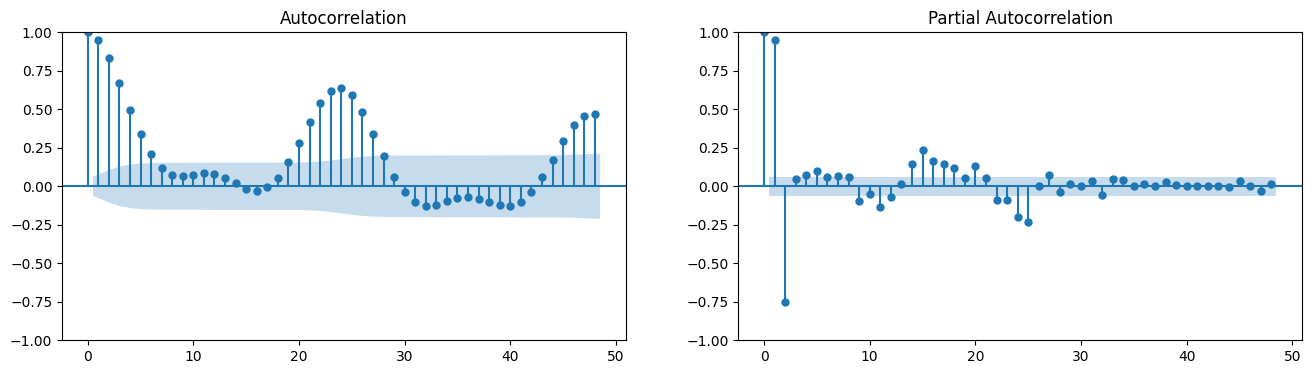

In [162]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))


seasonal_period = 24

sm.graphics.tsa.plot_acf(df_preprocessed[target_column], lags=seasonal_period*2, ax=axes[0])
sm.graphics.tsa.plot_pacf(df_preprocessed[target_column], lags=seasonal_period*2, ax=axes[1])

plt.show()

Applying SARIMA Model

In [163]:


seasonal_order = (1, 1, 1, seasonal_period)  

model = SARIMAX(train[target_column], order=(1, 1, 1), seasonal_order=seasonal_order)

# Fitting
model_fit = model.fit()

# Saving
with open('sarima_model.pkl', 'wb') as file:

    pickle.dump(model_fit, file)

# Loading
with open('sarima_model.pkl', 'rb') as file:

    loaded_model = pickle.load(file)



C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Forecasting

In [164]:

forecast_steps = len(test)

forecast = loaded_model.predict(start=len(train), end=len(train) + forecast_steps - 1)

C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [165]:

rmse_loaded = np.sqrt(mean_squared_error(test[target_column], forecast))

mae_loaded = mean_absolute_error(test[target_column], forecast)

mape_loaded = mean_absolute_percentage_error(test[target_column], forecast)


print(f'Root Mean Squared Error = {rmse_loaded}')
print("")
print(f'Mean Absolute Error = {mae_loaded}')
print("")
print(f'Mean Absolute Percentage Error = {mape_loaded}')

Root Mean Squared Error = 0.5519197461815841

Mean Absolute Error = 0.5071715895878602

Mean Absolute Percentage Error = 5.632315443673668


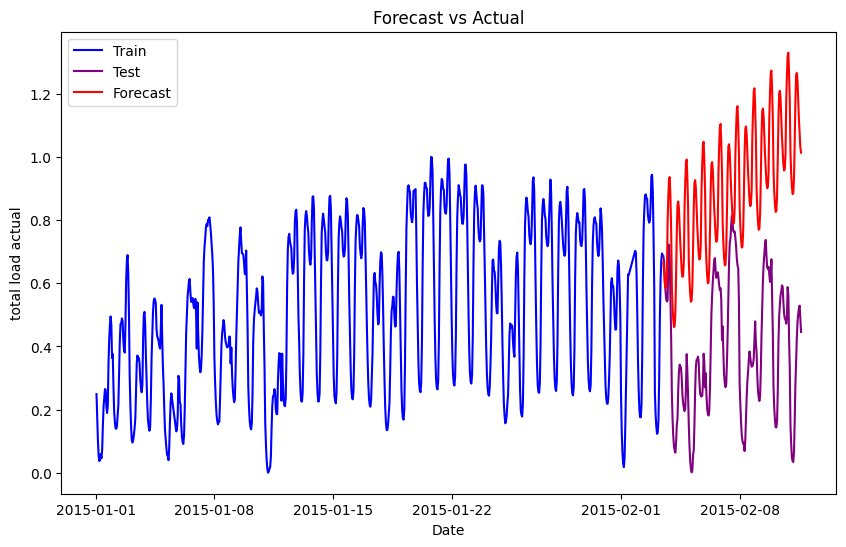

In [166]:

plt.figure(figsize=(10, 6))

plt.plot(train.index, train[target_column], label='Train',color='blue')
plt.plot(test.index, test[target_column], label='Test',color='purple')
plt.plot(test.index, forecast, label='Forecast', color='red')

plt.legend()

plt.xlabel('Date')
plt.ylabel(target_column)

plt.title(f'Forecast vs Actual')

plt.show()


# Exponential Smoothing (ETS)

In [178]:
import pandas as pd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pickle


In [179]:
file_path = 'new_energy_data.csv'

df = pd.read_csv(file_path)



# Converting 'time' column to datetime and setting it as index

df['time'] = pd.to_datetime(df['time'], utc=True)

df['time'] = df['time'].dt.date

df.set_index('time', inplace=True)



data = df['total load actual']

In [180]:
# Splitting the data into training and validation sets

split_point = int(len(data) * 0.8)

train, valid = data[:split_point], data[split_point:]

Applying Simple Exponential Smoothing

In [181]:
ses = SimpleExpSmoothing(train).fit()

ses_pred = ses.forecast(len(valid))

ses_rmse = np.sqrt(mean_squared_error(valid, ses_pred))

C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in

 Applying Holt's Linear Trend Model

In [182]:

hltm = Holt(train).fit()

hltm_pred = hltm.forecast(len(valid))

hltm_rmse = np.sqrt(mean_squared_error(valid, hltm_pred))

C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in

Applying Holt-Winters Seasonal Model

In [183]:

hwm = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()

hwm_pred = hwm.forecast(len(valid))

hwm_rmse = np.sqrt(mean_squared_error(valid, hwm_pred))

C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in

Forecastng

In [184]:

def plot_forecast(train, valid, predictions, title, rmse):

    plt.figure(figsize=(10, 6))

    plt.plot(train.index, train, label='Train')
    plt.plot(valid.index, valid, label='Valid')
    plt.plot(valid.index, predictions, label='Forecast')

    plt.title(f'{title} - RMSE: {rmse:.2f}')

    plt.legend()

    plt.show()

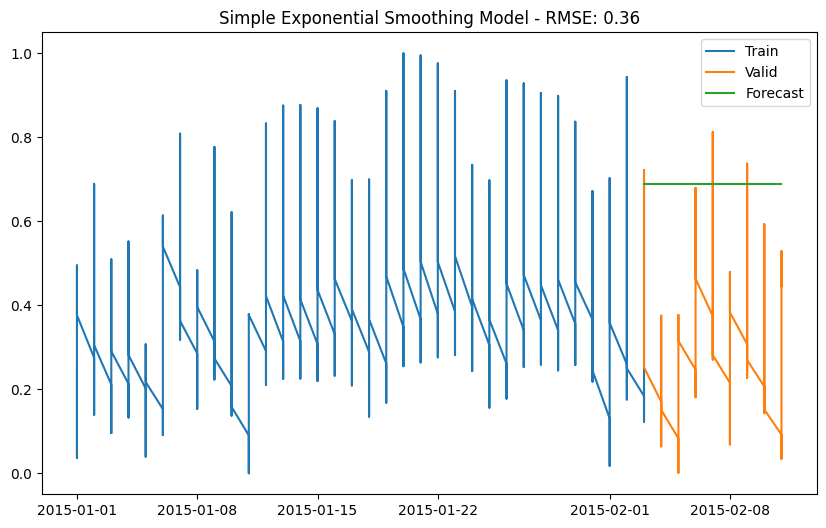

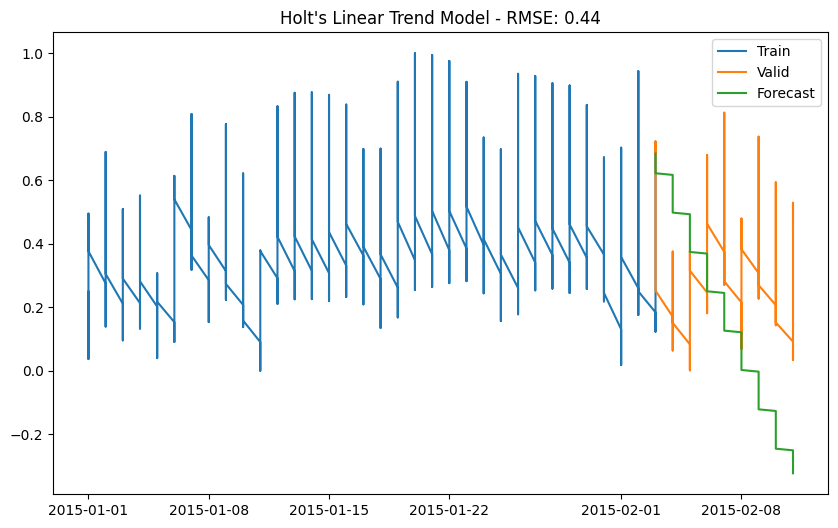

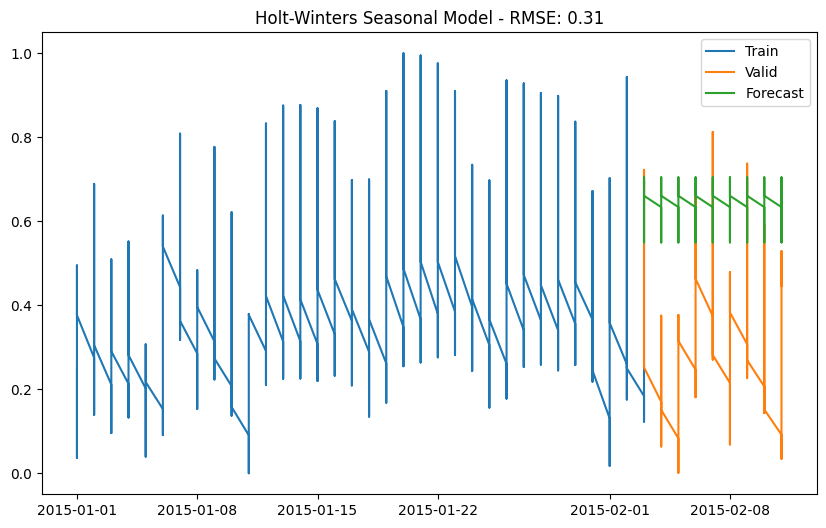

In [185]:
plot_forecast(train, valid, ses_pred, 'Simple Exponential Smoothing Model', ses_rmse)

plot_forecast(train, valid, hltm_pred, "Holt's Linear Trend Model", hltm_rmse)

plot_forecast(train, valid, hwm_pred, "Holt-Winters Seasonal Model", hwm_rmse)


In [186]:
# Saving
 
with open('ses_model.pkl', 'wb') as f:
    pickle.dump(ses, f)

with open('holt_model.pkl', 'wb') as f:
    pickle.dump(hltm, f)

with open('holt_winters_model.pkl', 'wb') as f:
    pickle.dump(hwm, f)

In [190]:

print(f'Simple Exponential Smoothing RMSE = {ses_rmse:.2f}')
print("")
print(f"Holt's Linear Trend Model RMSE = {hltm_rmse:.2f}")
print("")
print(f'Holt-Winters Seasonal Model RMSE = {hwm_rmse:.2f}')


Simple Exponential Smoothing RMSE = 0.36

Holt's Linear Trend Model RMSE = 0.44

Holt-Winters Seasonal Model RMSE = 0.31


# Prophet

In [191]:
from prophet import Prophet

In [192]:

df = df.head(1000)

# The 'time' column is parsed as datetime
df['time'] = pd.to_datetime(df['time'], utc=True)

df['time'] = df['time'].dt.date


# Preparing the data
df_prophet = df[['time', 'total load actual']].rename(columns={'time': 'ds', 'total load actual': 'y'})


# Making sure that 'ds' is datetime type
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'], errors='coerce')


# Checking for null values which might indicate parsing errors

if df_prophet['ds'].isnull().any():
    print("*** There are null values in the 'ds' column ***")


df_prophet.dropna(subset=['ds'], inplace=True)


# Splitting the data into training set and test set

train_size = int(len(df_prophet) * 0.8)

train, test = df_prophet.iloc[:train_size], df_prophet.iloc[train_size:]


Defining and fitting the model

In [195]:

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=True
)
model.fit(train)


# Saving
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Loading
with open('prophet_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)



DEBUG:cmdstanpy:cmd: where.exe tbb.dll
cwd: None
DEBUG:cmdstanpy:TBB already found in load path
DEBUG:cmdstanpy:input tempfile: C:\Users\romai\AppData\Local\Temp\tmp5uj68oiy\0i6mkgq_.json
DEBUG:cmdstanpy:input tempfile: C:\Users\romai\AppData\Local\Temp\tmp5uj68oiy\vipq37rq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['C:\\Users\\romai\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=63634', 'data', 'file=C:\\Users\\romai\\AppData\\Local\\Temp\\tmp5uj68oiy\\0i6mkgq_.json', 'init=C:\\Users\\romai\\AppData\\Local\\Temp\\tmp5uj68oiy\\vipq37rq.json', 'output', 'file=C:\\Users\\romai\\AppData\\Local\\Temp\\tmp5uj68oiy\\prophet_model7pn7n0tg\\prophet_model-20240514221406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:14:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:c

Forecasting

In [196]:
# Creating a dataframe to hold predictions

future = loaded_model.make_future_dataframe(periods=len(test), freq='D')


# Making  predictions
forecast = loaded_model.predict(future)

# Aligning the actual test values with the predicted values

test['yhat'] = forecast['yhat'].iloc[-len(test):].values

C:\Users\romai\AppData\Local\Temp\ipykernel_24860\3799269202.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['yhat'] = forecast['yhat'].iloc[-len(test):].values


In [197]:
rmse_loaded = np.sqrt(mean_squared_error(test['y'], test['yhat']))

mae_loaded = mean_absolute_error(test['y'], test['yhat'])

mape_loaded = mean_absolute_percentage_error(test['y'], test['yhat'])


print(f'Root Mean Squared Error = {rmse_loaded}')
print("")
print(f'Mean Absolute Error = {mae_loaded}')
print("")
print(f'Mean Absolute Percentage Error = {mape_loaded}')


Root Mean Squared Error = 1.6378190084834423

Mean Absolute Error = 1.47634856593358

Mean Absolute Percentage Error = 13.409766157454586


C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


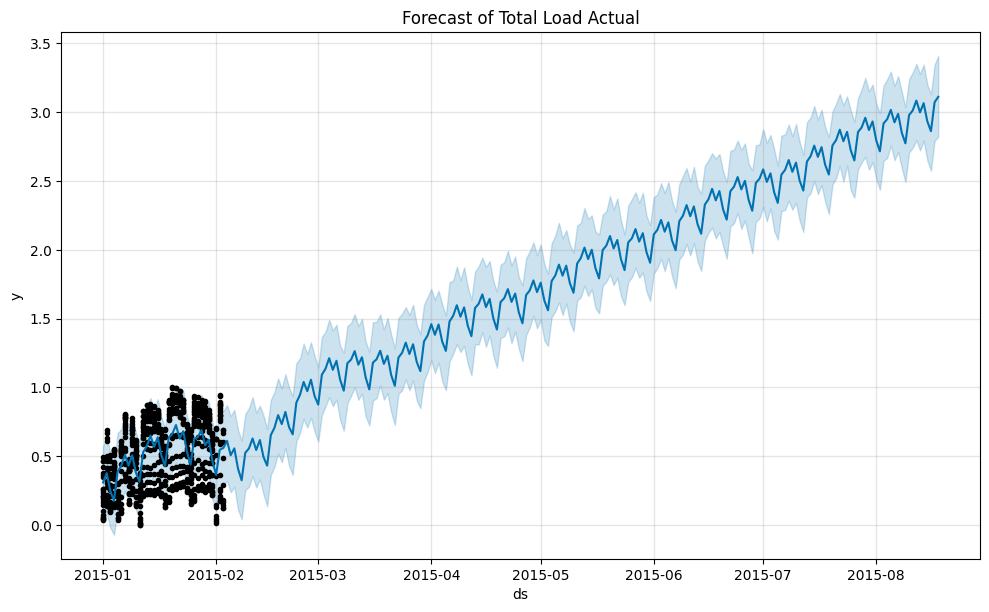

C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Lo

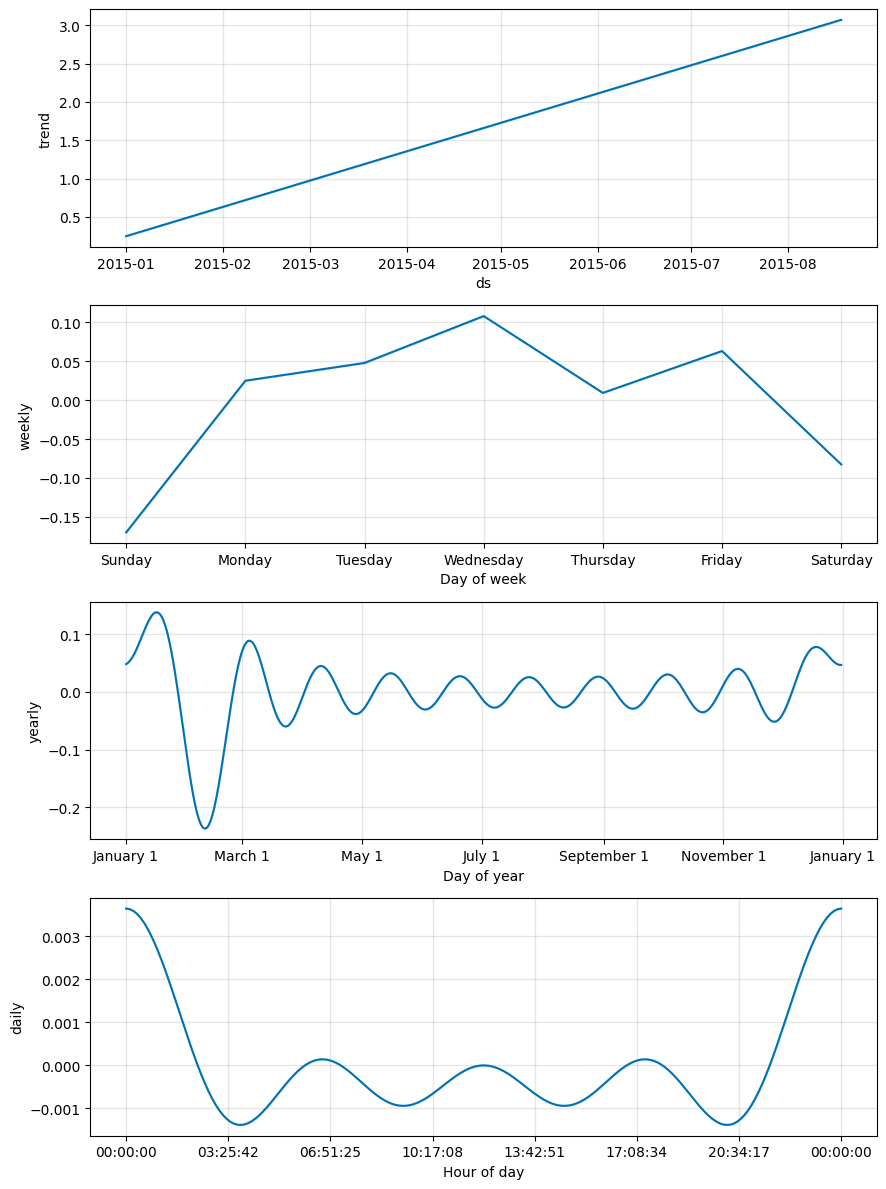

In [198]:

fig1 = loaded_model.plot(forecast)

plt.title('Forecast of Total Load Actual')

plt.show()



fig2 = loaded_model.plot_components(forecast)

plt.show()

# Support Vector Regression (SVR)

In [199]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler

In [202]:
# Target column and Feature columns

target_column = 'total load actual'
feature_columns = ['total load forecast']  

df = df.dropna(subset=[target_column])

Preparing the data

In [203]:

X = df[feature_columns]
y = df[target_column]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


scaler_X = StandardScaler()
scaler_y = StandardScaler()


X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)


y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

Defining the SVR model with hyperparameter tuning using GridSearchCV

In [205]:

param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto']
}


grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train_scaled)


best_params = grid_search.best_params_
print(f'BEST PARAMETERS {best_params}')


# Training the SVR model 

best_svr = SVR(kernel=best_params['kernel'], C=best_params['C'], gamma=best_params['gamma'])

best_svr.fit(X_train_scaled, y_train_scaled)


BEST PARAMETERS {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


SVR(C=0.1, kernel='linear')

Forecasting

In [206]:

y_train_pred_scaled = best_svr.predict(X_train_scaled)

y_test_pred_scaled = best_svr.predict(X_test_scaled)



y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()


In [207]:
rmse_loaded = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_loaded = mean_absolute_error(y_test, y_test_pred)

mape_loaded = mean_absolute_percentage_error(y_test, y_test_pred)



print(f'Root Mean Squared Error = {rmse_loaded}')
print("")
print(f'Mean Absolute Error = {mae_loaded}')
print("")
print(f'Mean Absolute Percentage Error = {mape_loaded}')



Root Mean Squared Error = 0.02596307109879635

Mean Absolute Error = 0.021018575657100497

Mean Absolute Percentage Error = 0.23749220173701233


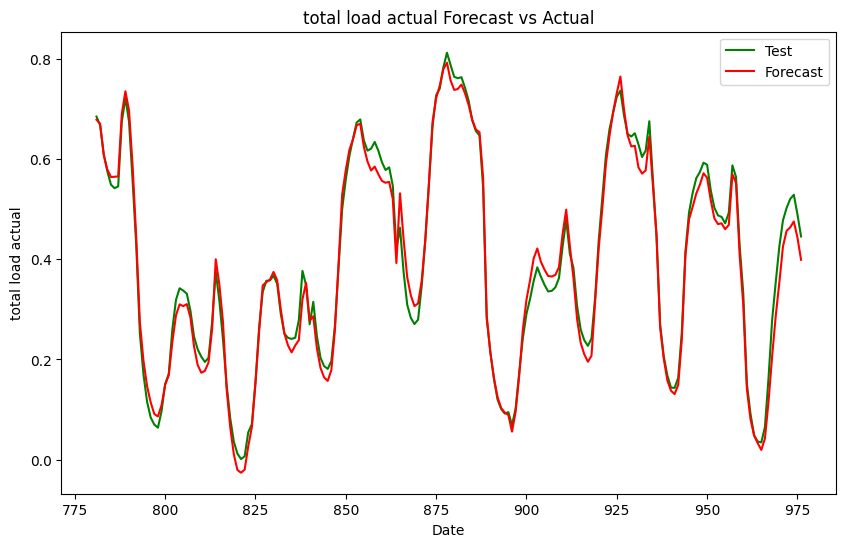

In [209]:
plt.figure(figsize=(10, 6))

plt.plot(y_test.index, y_test, label='Test', color='green')
plt.plot(y_test.index, y_test_pred, label='Forecast', color='red')

plt.legend()

plt.xlabel('Date')
plt.ylabel(target_column)

plt.title(f'{target_column} Forecast vs Actual')

plt.show()


# Long Short-Term Memory (LSTM)

In [213]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
# Converting 'time' column to datetime and set as index

df['time'] = pd.to_datetime(df['time'], utc=True)
df['time'] = df['time'].dt.date

df.set_index('time', inplace=True)

In [214]:
# Select target and feature columns

target_column = 'total load actual'
features_columns = df.columns[df.columns != target_column]

features = df[features_columns].values
target = df[target_column].values.reshape(-1, 1)  # Reshape target to (-1, 1) for LSTM compatibility


# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)


# Standardize the data
scaler_X = StandardScaler()

scaler_y = StandardScaler()


X_train_scaled = scaler_X.fit_transform(X_train)

X_test_scaled = scaler_X.transform(X_test)


y_train_scaled = scaler_y.fit_transform(y_train)

y_test_scaled = scaler_y.transform(y_test)


# Reshape input to be samples, time steps, features

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

 Defining and Fitting the LSTM model

In [215]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[2])))  
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


# Fitting model
history = model.fit(X_train_scaled, y_train_scaled, epochs=20, batch_size=72, validation_data=(X_test_scaled, y_test_scaled), verbose=2)



Epoch 1/20


C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


11/11 - 2s - 181ms/step - loss: 0.9411 - val_loss: 0.7403
Epoch 2/20
11/11 - 0s - 8ms/step - loss: 0.7055 - val_loss: 0.5514
Epoch 3/20
11/11 - 0s - 7ms/step - loss: 0.4988 - val_loss: 0.3760
Epoch 4/20
11/11 - 0s - 7ms/step - loss: 0.3212 - val_loss: 0.2328
Epoch 5/20
11/11 - 0s - 8ms/step - loss: 0.1920 - val_loss: 0.1469
Epoch 6/20
11/11 - 0s - 7ms/step - loss: 0.1186 - val_loss: 0.1003
Epoch 7/20
11/11 - 0s - 15ms/step - loss: 0.0800 - val_loss: 0.0743
Epoch 8/20
11/11 - 0s - 8ms/step - loss: 0.0602 - val_loss: 0.0558
Epoch 9/20
11/11 - 0s - 7ms/step - loss: 0.0473 - val_loss: 0.0416
Epoch 10/20
11/11 - 0s - 8ms/step - loss: 0.0394 - val_loss: 0.0338
Epoch 11/20
11/11 - 0s - 8ms/step - loss: 0.0328 - val_loss: 0.0293
Epoch 12/20
11/11 - 0s - 8ms/step - loss: 0.0284 - val_loss: 0.0252
Epoch 13/20
11/11 - 0s - 8ms/step - loss: 0.0250 - val_loss: 0.0223
Epoch 14/20
11/11 - 0s - 8ms/step - loss: 0.0225 - val_loss: 0.0203
Epoch 15/20
11/11 - 0s - 8ms/step - loss: 0.0205 - val_loss: 0.01

Extracting the loss and validation loss 

In [216]:
loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)


C:\Users\romai\AppData\Local\Temp\ipykernel_24860\1010560336.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(epochs, loss, 'bo', label='Training loss', color='red')
C:\Users\romai\AppData\Local\Temp\ipykernel_24860\1010560336.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, val_loss, 'b', label='Validation loss', color='green')


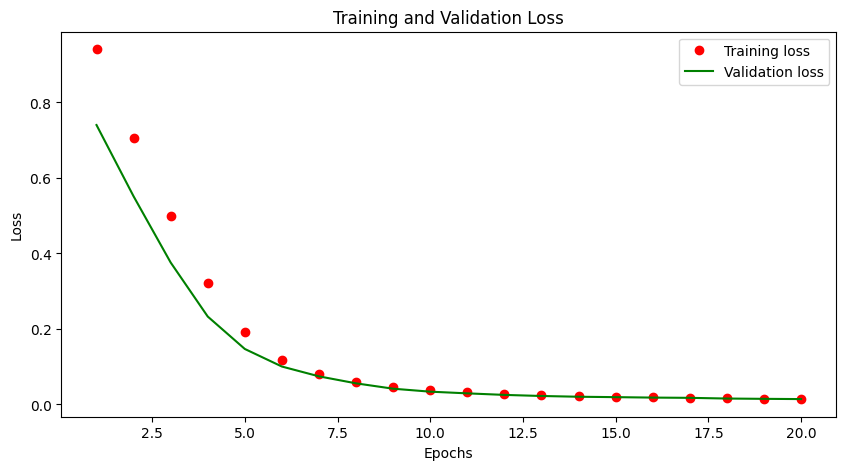

In [221]:
plt.figure(figsize=(10, 5))

plt.plot(epochs, loss, 'bo', label='Training loss', color='red')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color='green')

plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

Forecasting

In [223]:

model.save('my_lstm_model.h5')


In [224]:
# Making Predictions

y_train_pred_scaled = model.predict(X_train_scaled)

y_test_pred_scaled = model.predict(X_test_scaled)


y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


In [225]:

rmse_loaded = np.sqrt(mean_squared_error(y_test, y_test_pred))

mae_loaded = mean_absolute_error(y_test, y_test_pred)

mape_loaded = mean_absolute_percentage_error(y_test, y_test_pred)



print(f'Root Mean Squared Error = {rmse_loaded}')
print("")
print(f'Mean Absolute Error = {mae_loaded}')
print("")
print(f'Mean Absolute Percentage Error = {mape_loaded}')



Root Mean Squared Error = 0.03005519513225891

Mean Absolute Error = 0.023841578663976473

Mean Absolute Percentage Error = 0.13853154541582557


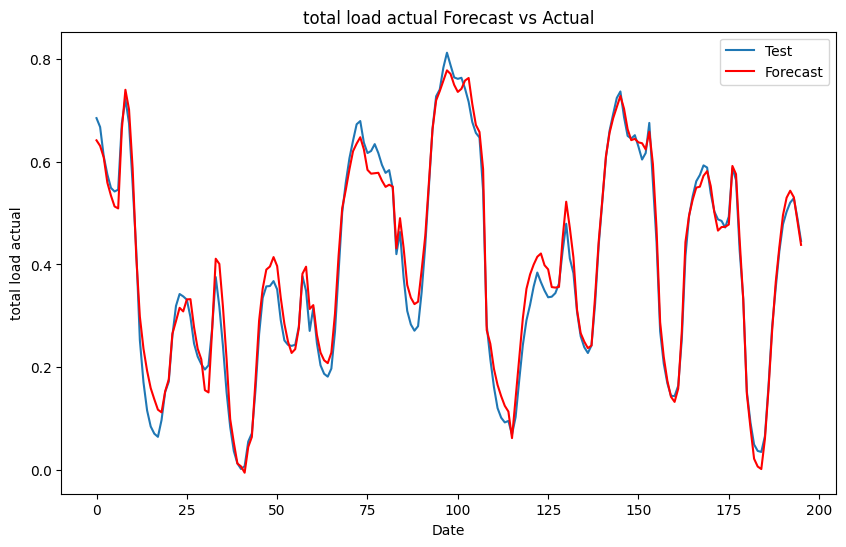

In [226]:
plt.figure(figsize=(10, 6))

plt.plot(y_test, label='Test')
plt.plot(y_test_pred, label='Forecast', color='red')

plt.legend()

plt.xlabel('Date')
plt.ylabel(target_column)

plt.title(f'{target_column} Forecast vs Actual')

plt.show()